# **Import Libraries**

In [0]:
# import libraries
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix
import pandas_datareader.data as web

import plotly.plotly as py
import plotly.tools as tls

import seaborn as sns; sns.set(color_codes=True)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


import warnings
warnings.filterwarnings('ignore')

Good explenation on regression, but using statmodels instead of sklearn

https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

# **Get Data**

In [0]:
# # Get Data
# # path of data
# path = "c:\\xxx\\yyy\\name.csv"
all_data = pd.read_csv('BeerConsumption_Original.csv', delimiter = ',')

In [3]:
# Choose relevant population
df = all_data.copy()       # create a copy of the data
df.index                   # index the data
df.head()

,date,temp_min,temp_med,temp_max,precipitation,weekend,consumption
0,01-01-15,23.9,27.30,32.5,0.0,0,25461
1,02-01-15,24.5,27.02,33.5,0.0,0,28972
2,03-01-15,22.4,24.82,29.9,0.0,1,30814
3,04-01-15,21.5,23.98,28.6,1.2,1,29799
4,05-01-15,21.0,23.82,28.3,0.0,0,28900


# **Prepare Data and EDA**

In [0]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)     # transform column 'date' to date field
df['consumption'] = df['consumption'].astype(int)          # transform column 'consumption' to int field



In [5]:
df.info()            # provide information of the df columns
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
date             365 non-null datetime64[ns]
temp_min         365 non-null float64
temp_med         365 non-null float64
temp_max         365 non-null float64
precipitation    365 non-null float64
weekend          365 non-null int64
consumption      365 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 20.0 KB


,temp_min,temp_med,temp_max,precipitation,weekend,consumption
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,17.461370,21.226356,26.611507,5.196712,0.284932,25401.367123
std,2.826185,3.180108,4.317366,12.417844,0.452001,4399.142703
min,10.600000,12.900000,14.500000,0.000000,0.000000,14343.000000
25%,15.300000,19.020000,23.800000,0.000000,0.000000,22008.000000
50%,17.900000,21.380000,26.900000,0.000000,0.000000,24867.000000
75%,19.600000,23.280000,29.400000,3.200000,1.000000,28631.000000
max,24.500000,28.860000,36.500000,94.800000,1.000000,37937.000000


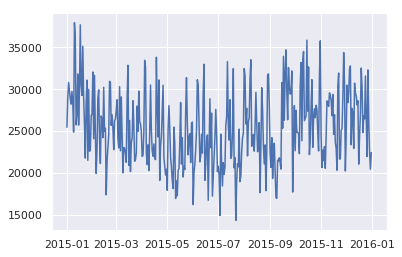

In [6]:
# plot original data over time
fig = plt.figure()
ax = plt.axes()

x = df['date']
y = df['consumption']
ax.plot(x, y);

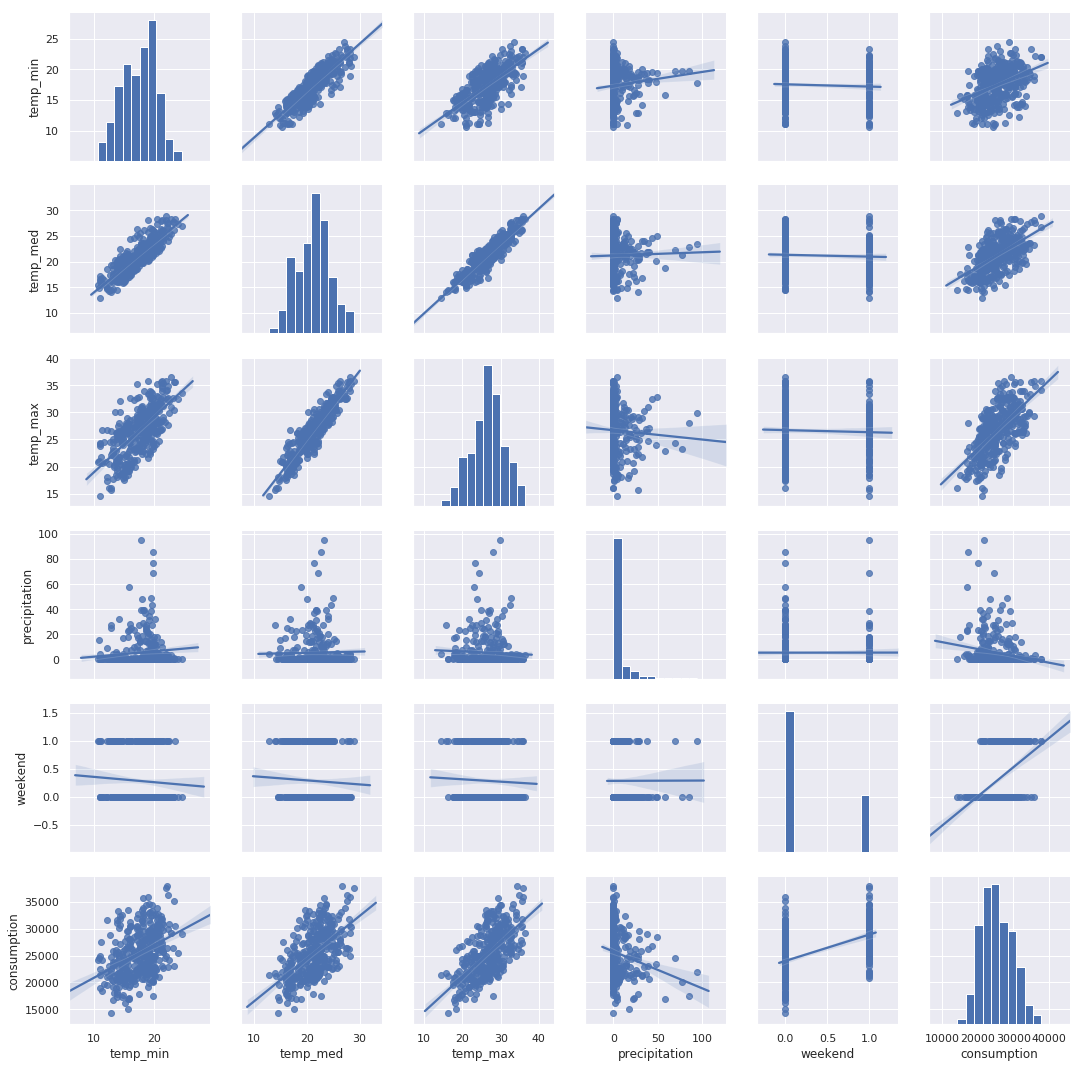

In [7]:
# sns.pairplot(df, hue = 'weekend', kind = 'reg')       # plot correlations between features of original data
sns.pairplot(df, kind = 'reg')       # plot correlations between features of original data

### **Initial Analysis and Data Augmentation**
1. **Drop 'temp_min' and 'temp_med'**. There seems to be multi-colinearity between the temperature fields ('temp_min', 'temp_med', 'temp_max'). Keeping 'temp_max' makes more sense re beer consumption. Also, 'temp_max' has a more symmetrical distribution making it more attractive for analysis.
2. On average, there seems to be more beer consumption on the weekend than on weekdays.
3. **Add two fields: 'day' and 'month'**. Looking at consumption over time (by days over the year) is messy. We need to aggregate to day level and month level.
4. **Add 2 fields: precip_lte10 precip_gt10**: We see a slight trend of decreasing beer consumption as precipitation increases. 

In [0]:
df1 = df.drop(['temp_min', 'temp_med'], axis = 1)         # dropping 'temp_min' and 'temp_med' columns

In [0]:
# converting dates to days of week

# creating a temp copy of the date field for day and month conversion
df1['date_temp'] = pd.to_datetime(df1['date'])

df1['day_of_week'] = df1['date_temp'].dt.day_name()
df1['day_of_week'] = df1['day_of_week'].replace({'Sunday': 1, 'Monday': 2, 'Tuesday':3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7})

In [0]:
# converting dates to months
df1['date_temp'] = pd.to_datetime(df1['date'])
df1['month'] = df1['date_temp'].dt.month_name()
df1['month'] = df1['month'].replace({'January':1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12})

In [0]:
# converting dates to days of year
df1['day_of_year'] = df1['date'].dt.dayofyear

In [0]:
# delete date field
df1 = df1.drop('date', axis = 1)

In [0]:
# ordering the data so consumption is the last columns (standard practice)
cols = ['day_of_year', 'month', 'day_of_week', 'temp_max', 'precipitation', 'weekend', 'consumption']
df1 = df1[cols]

In [0]:
df1.head()

,day_of_year,month,day_of_week,temp_max,precipitation,weekend,consumption
0,1,1,5,32.5,0.0,0,25461
1,2,1,6,33.5,0.0,0,28972
2,3,1,7,29.9,0.0,1,30814
3,4,1,1,28.6,1.2,1,29799
4,5,1,2,28.3,0.0,0,28900


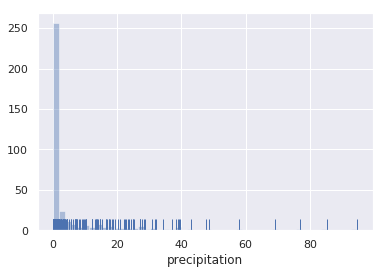

In [14]:
# check distribution of precipitation
x = df1['precipitation']
sns.distplot(x, kde=False, rug=True);

In [0]:
# categorizing precipitation 0-5mm and above 5mm
cat = 5
def preciptation_cat(row):
  if row['precipitation'] < cat:
    return 0
  else:
    return 1

df1['precip_cat'] = df1.apply(preciptation_cat, axis = 1)

# dropping precipitation column
# df1 = df1.drop('precipitation', axis = 1)

In [0]:
# ordering the data so consumption is the last columns (standard practice)
cols = ['day_of_year', 'month', 'day_of_week', 'temp_max', 'precipitation','precip_cat', 'weekend', 'consumption']
df1 = df1[cols]

In [17]:
df1.head()

,day_of_year,month,day_of_week,temp_max,precipitation,precip_cat,weekend,consumption
0,1,1,5,32.5,0.0,0,0,25461
1,2,1,6,33.5,0.0,0,0,28972
2,3,1,7,29.9,0.0,0,1,30814
3,4,1,1,28.6,1.2,0,1,29799
4,5,1,2,28.3,0.0,0,0,28900


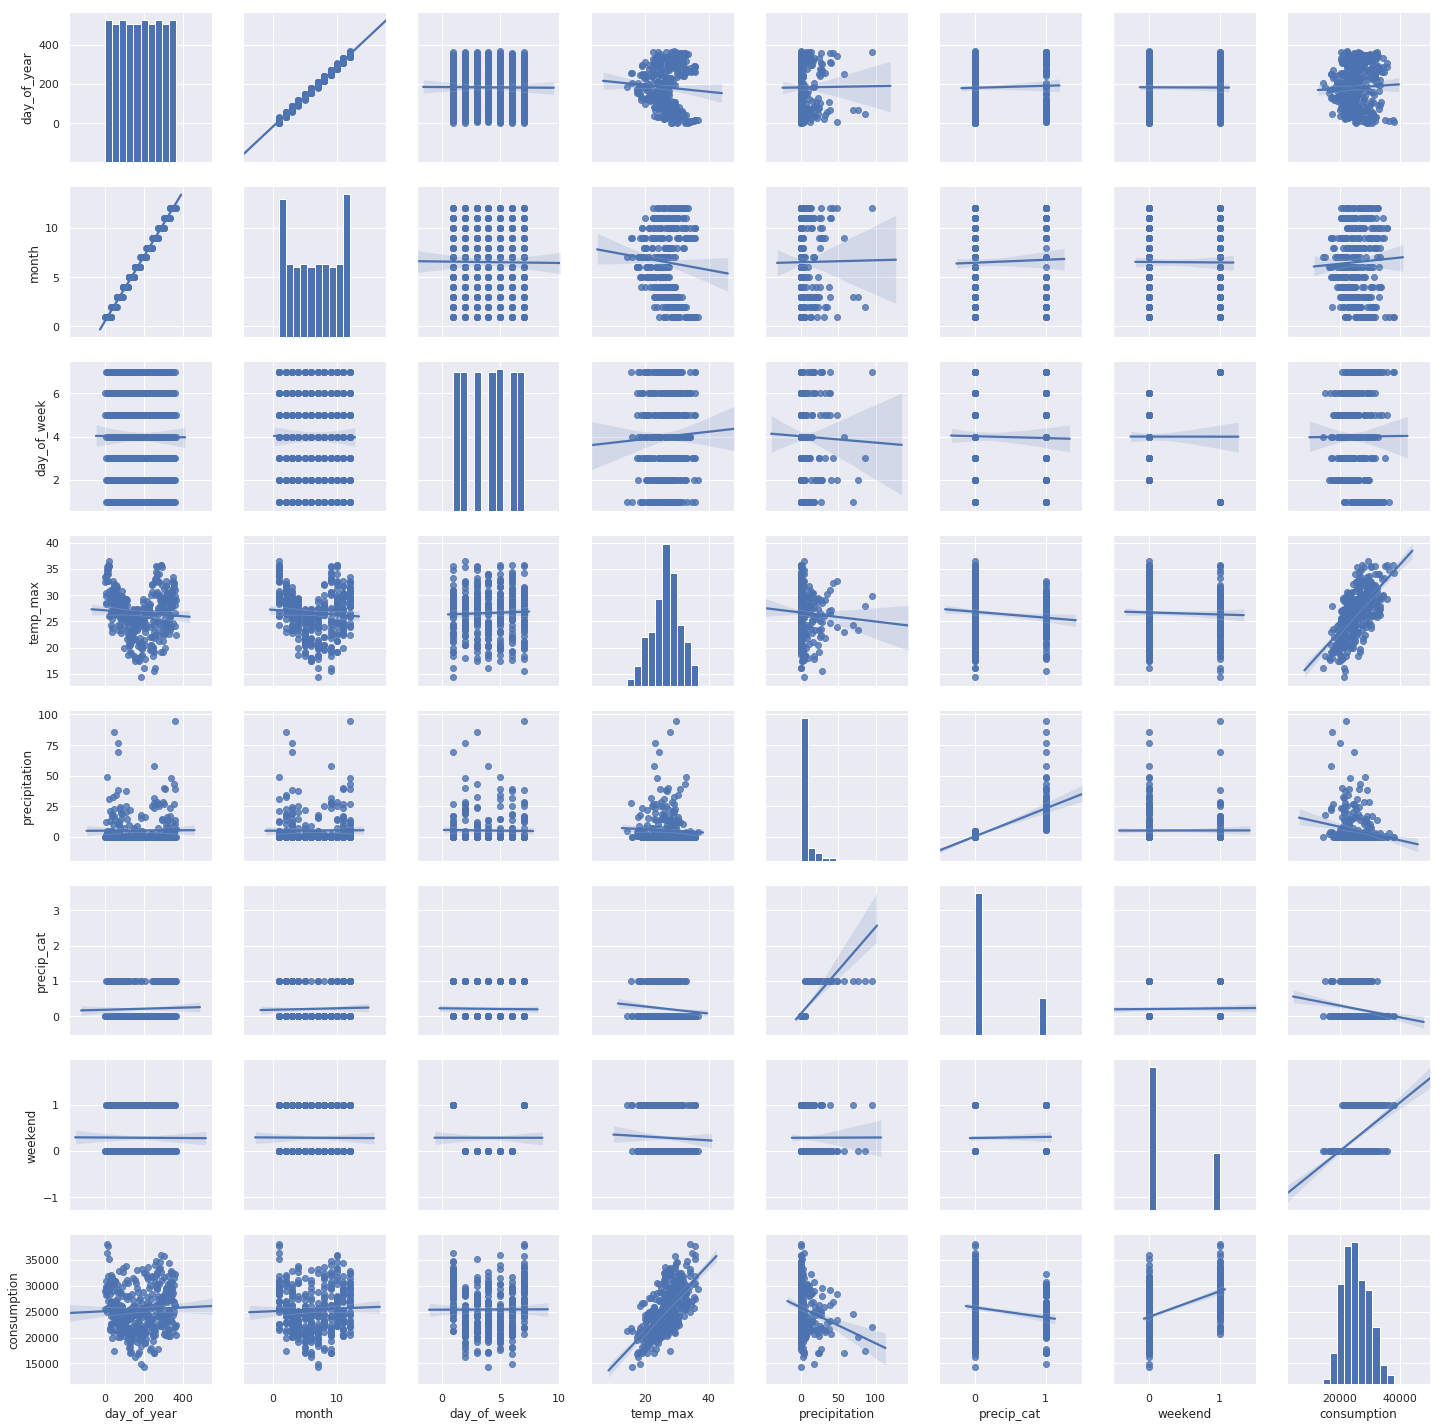

In [18]:
# sns.pairplot(df1, hue = 'weekend', kind = 'reg')       # plot correlations between features of augmented data - differentiator: weekend
sns.pairplot(df1, kind = 'reg')       # plot correlations between features of augmented data - differentiator: weekend

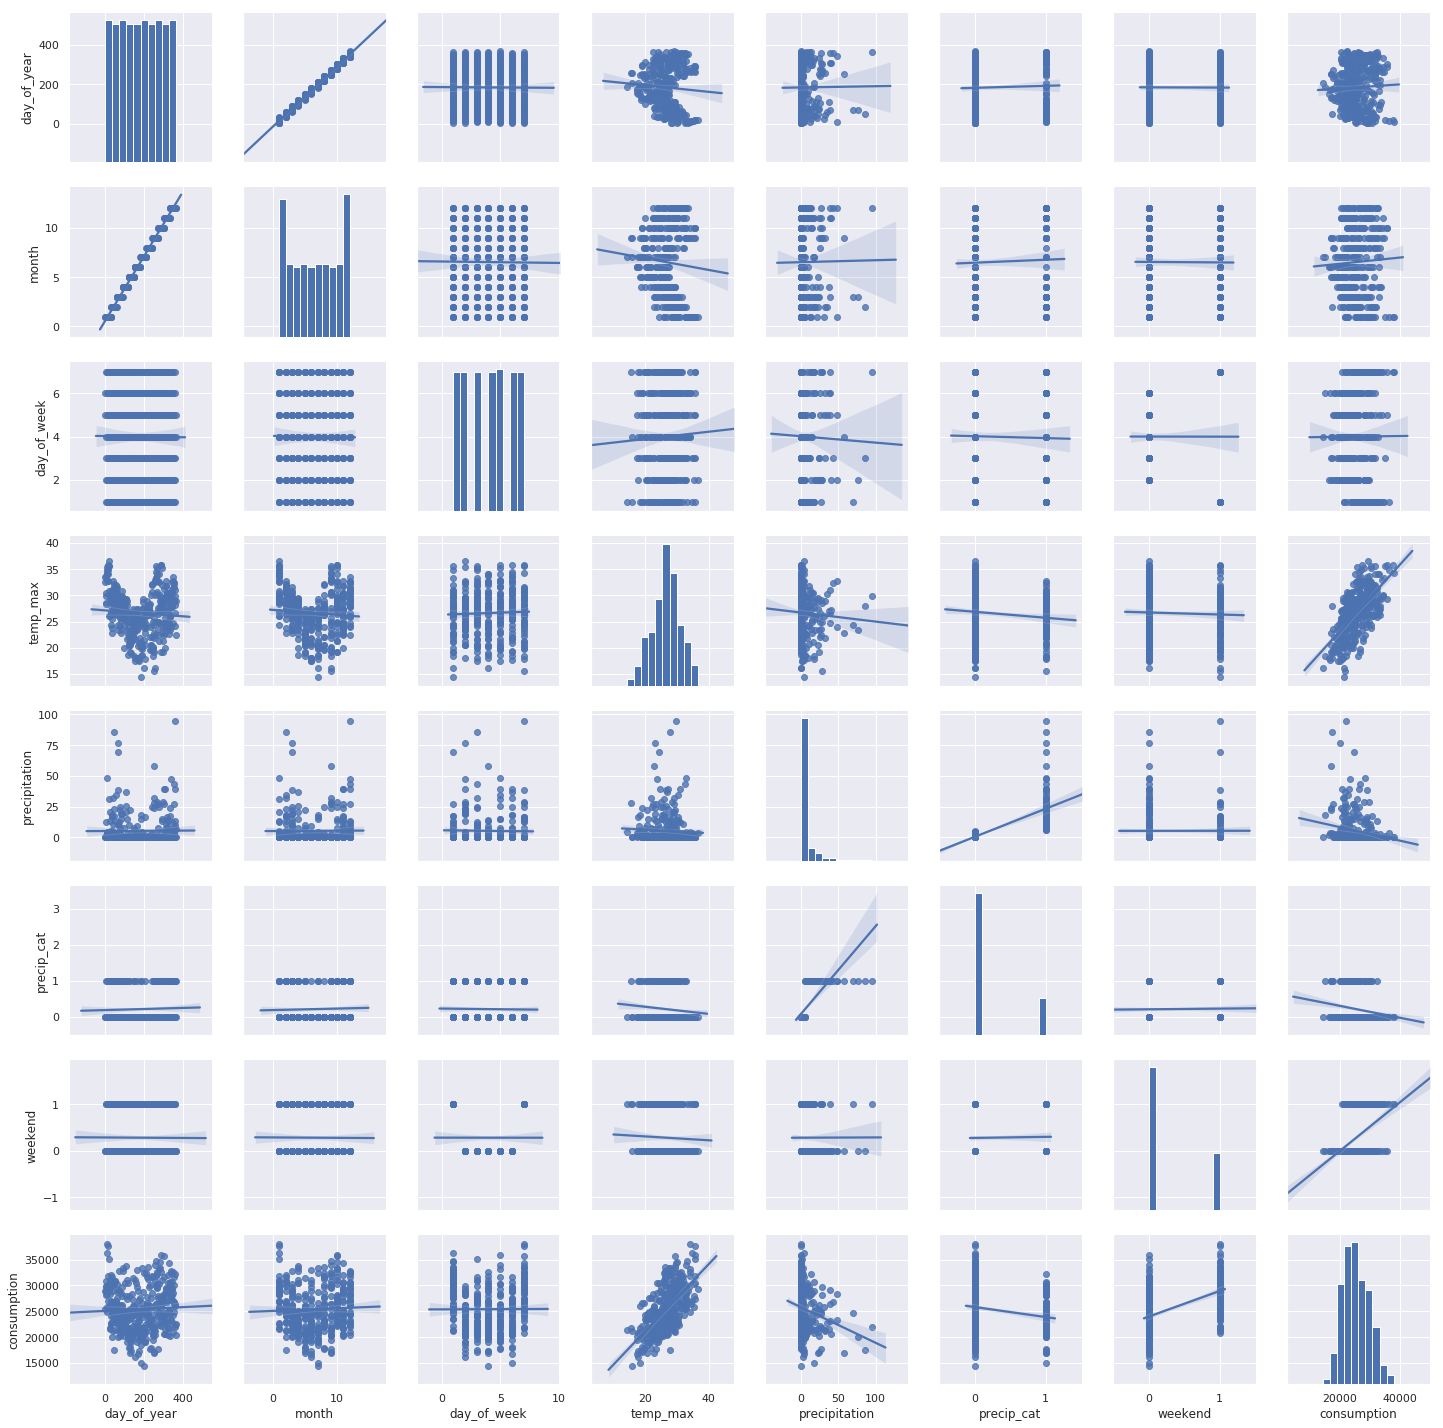

In [19]:
# sns.pairplot(df1, hue = 'precip_cat', kind = 'reg')       # plot correlations between features of augmented data  - differentiator: precipitation category
sns.pairplot(df1, kind = 'reg')       # plot correlations between features of augmented data  - differentiator: precipitation category

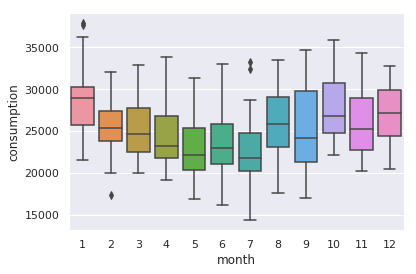

In [20]:
# plotting consumption distribution by month
x = df1['month']
y = df1['consumption']
ax = sns.boxplot(x=x, y=y, data=df1)

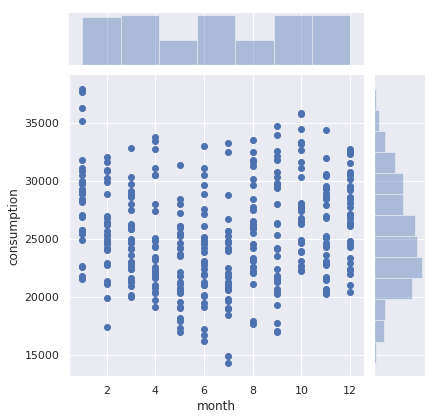

In [21]:
# plotting consumption distribution by month with precipiatin category differentiator
x = df1['month']
y = df1['consumption']
hue = 'weekend'
ax = sns.jointplot(x=x, y=y, data=df1)

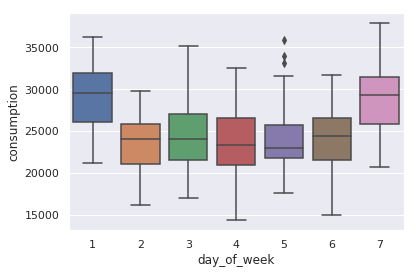

In [22]:
# plotting consumption distribution by day
x = df1['day_of_week']
y = df1['consumption']
ax = sns.boxplot(x=x, y=y, data=df1)

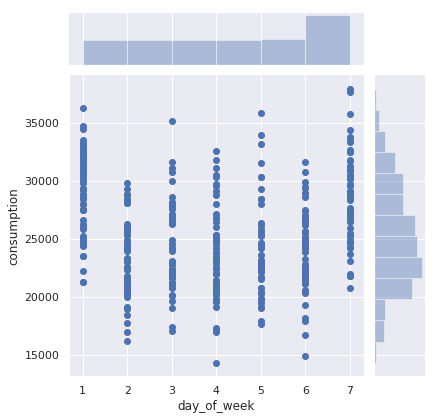

In [23]:
x = df1['day_of_week']
y = df1['consumption']
ax = sns.jointplot(x = x, y = y, data=df1)




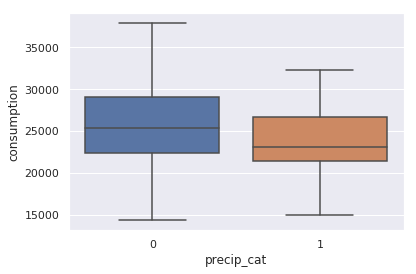

In [24]:
# plotting consumption distribution by precipitation category
x = df1['precip_cat']
y = df1['consumption']
ax = sns.boxplot(x=x, y=y, data=df1)

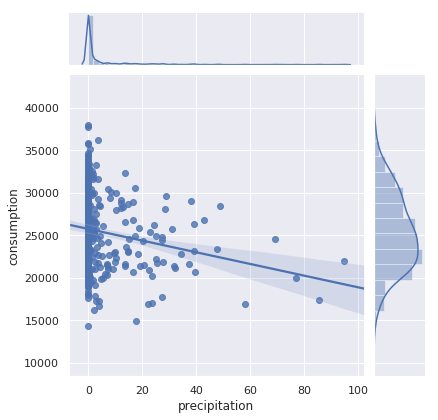

In [25]:
# plotting consumption distribution by precipitatio

cat = 5
x = df1['precipitation']
y = df1['consumption']

g = sns.jointplot(x = x, y = y, data=df1, kind="reg")



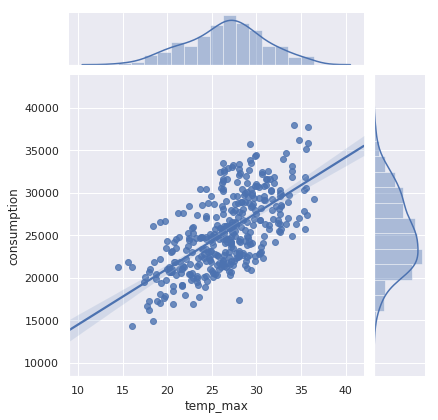

In [26]:
# plotting consumption distribution by maximum temperature
x = df1['temp_max']
y = df1['consumption']
g = sns.jointplot(x = x, y = y, data=df1,kind="reg")

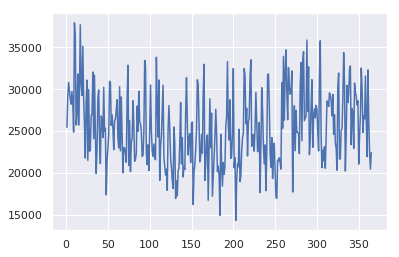

In [27]:
fig = plt.figure()
ax = plt.axes()

weekend = np.nan
# weekend = 1
# weekend = 0
if weekend not in (0,1):
  x = df1['day_of_year']
  y = df1['consumption']

else:
  x = df1.loc[df1['weekend'] == weekend, 'day_of_year']
  y = df1.loc[df1['weekend'] == weekend, 'consumption']
  
ax.plot(x, y);

### **EDA Conclusions**
1. Beer consumption is higher in the summer months. This correlates to beer consumption as temperature increases
2. Beer consumption is higher on the weekends (Saturday, Sunday) than on week days
3. Beer consumption is highest when there is no precipitation (rain falls). When categorizing the days that have and days that do not have precipitation, we see that there is no significant difference
4. Although there is a decreasing trend of consumption as precipitation increases, those that do drink when it rains, tend to consume the same amount of beer. Seeing the same downward trend when there is precipitation on weekends
4. Beer consumption increases as the daily max temperature increases

# **Split the Data and Fit the Model**

After EDA the selected features for the linear regression model are:
month, day, temp_max, precipitation, weekday, consumption

In [0]:
# choosing columns for lm
cols = ['day_of_year','month', 'day_of_week', 'temp_max','precip_cat','weekend', 'consumption']

df1 = df1[cols]


In [0]:
# split data
df_train, df_test = split(df1, train_size = 0.7, random_state=123456)

In [0]:
# Define X and y
# Fit model
X = df_train.drop(['consumption'], axis = 1)
y = df_train['consumption']

df_lm = LinearRegression().fit(X,y)


In [31]:
# create equasion string

def lm_equasion(model,X):
  
  feature_num = X.shape[1]
  equasion = 'y = ' + '{:.2f}'.format(model.intercept_)

  for coef, feature in zip(model.coef_, df_train.columns[:feature_num]):
    equasion += '{:+.2f}*{}'.format(coef, feature)
    
  return equasion

lm_equasion(df_lm, X)



'y = 7349.98+13.75*day_of_year-290.74*month-51.89*day_of_week+619.10*temp_max-1214.79*precip_cat+4964.76*weekend'

**Important**

Statistical inference is not included in sklearn.linear_model

It is supported in statmodels library

# **Apply model and visualize**

In [32]:
# create predicted values from linear regression model
df_train['consumption_pred'] = df_lm.predict(X).round(2)
# df_train['consumption_pred'] = round(df_train['consumption_pred'], 2)
df_train.head()


,day_of_year,month,day_of_week,temp_max,precip_cat,weekend,consumption,consumption_pred
38,39,2,1,29.5,1,1,29926,29266.23
124,125,5,3,20.8,1,0,21826,19121.91
85,86,3,6,30.8,0,0,24974,26417.19
7,8,1,5,32.8,1,0,28397,26001.38
283,284,10,1,30.0,0,1,34496,31833.65


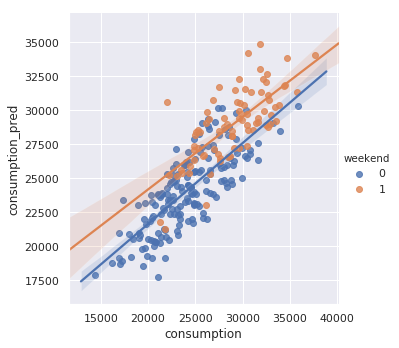

In [33]:
# visualize observed vs predicted consumption
x = df_train['consumption']
y = df_train['consumption_pred']

sns.lmplot(x="consumption", y="consumption_pred", hue="weekend", data=df_train)


In [0]:
# CREATE A RESIDUAL PLOT
df_train['lm_residual'] = df_train['consumption'] - df_train['consumption_pred']

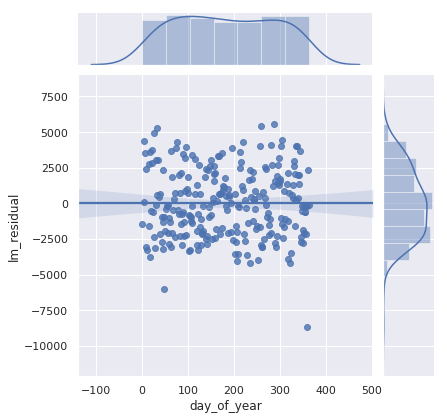

In [37]:
x = df_train['day_of_year']
y = df_train['lm_residual']

g = sns.jointplot(x = x, y = y, data=df1, kind="reg")

# **Assess the Model**

In [38]:
# get the rmse
df_rmse_train = np.sqrt(MSE(df_train['consumption'], 
                         df_train['consumption_pred']))
print ("RMSE = {:.2f}".format(df_rmse_train))

RMSE = 2367.09


# **Validate the Model**

In [39]:
# apply model to test data

df_train.head()


,day_of_year,month,day_of_week,temp_max,precip_cat,weekend,consumption,consumption_pred,lm_residual
38,39,2,1,29.5,1,1,29926,29266.23,659.77
124,125,5,3,20.8,1,0,21826,19121.91,2704.09
85,86,3,6,30.8,0,0,24974,26417.19,-1443.19
7,8,1,5,32.8,1,0,28397,26001.38,2395.62
283,284,10,1,30.0,0,1,34496,31833.65,2662.35


In [40]:
df_test.head()

,day_of_year,month,day_of_week,temp_max,precip_cat,weekend,consumption
200,201,7,2,25.1,0,0,20620
41,42,2,4,30.4,0,0,26805
9,10,1,7,34.2,0,1,37937
36,37,2,6,25.4,1,0,22821
364,365,12,5,29.0,0,0,22446


In [41]:
X = df_test.drop(['consumption'], axis = 1)
y = df_test['consumption']


df_test['consumption_pred'] = df_lm.predict(X)
df_test.head()

,day_of_year,month,day_of_week,temp_max,precip_cat,weekend,consumption,consumption_pred
200,201,7,2,25.1,0,0,20620,23514.311579
41,42,2,4,30.4,0,0,26805,25959.032007
9,10,1,7,34.2,0,1,37937,32971.388976
36,37,2,6,25.4,1,0,22821,21476.209459
364,365,12,5,29.0,0,0,22446,26574.582402


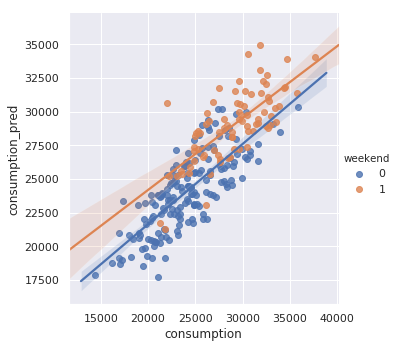

In [42]:
# differentiator: weekend

x = df_test['consumption']
y = df_test['consumption_pred']

sns.lmplot(x="consumption", y="consumption_pred", hue="weekend", data=df_train)

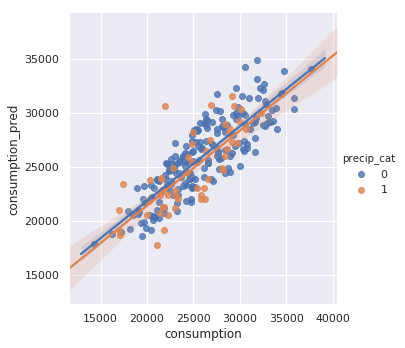

In [43]:
# differentiator: precipitation category

x = df_test['consumption']
y = df_test['consumption_pred']

sns.lmplot(x="consumption", y="consumption_pred", hue="precip_cat", data=df_train)

In [0]:
# CREATE A RESIDUAL PLOT
df_test['lm_residual'] = df_test['consumption'] - df_test['consumption_pred']

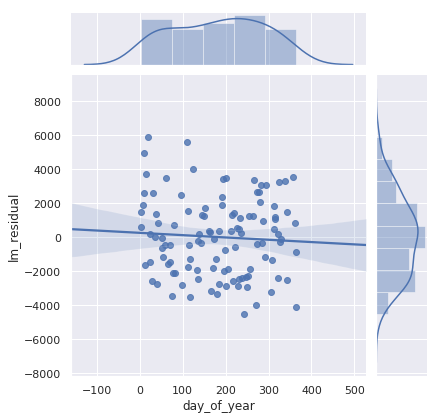

In [45]:
x = df_test['day_of_year']
y = df_test['lm_residual']

g = sns.jointplot(x = x, y = y, data=df1, kind="reg")

In [46]:
# Calculate RMSE on Test data
df_rmse_test = np.sqrt(MSE(df_test['consumption'], 
                         df_test['consumption_pred']))
print ("RMSE = {:.2f}".format(df_rmse_test))

RMSE = 2273.70


In [0]:
print(round(df_rmse_train,2), round(df_rmse_test,2))

2367.09 2273.7
